<a href="https://colab.research.google.com/github/bhanukad610/Fare-Classification/blob/master/Submission_Fare_Classification_with_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Import Libraries

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

### Functions : Clean

In [0]:
import datetime
from datetime import timedelta

def getGeneralDataFromDateTimeObj(time):
  datetimeFormat = '%m/%d/%Y %H:%M'
  dateTimeObj = datetime.datetime.strptime(time, datetimeFormat)
  return [float(dateTimeObj.month), float(dateTimeObj.day), float(dateTimeObj.hour), float(dateTimeObj.minute), float(dateTimeObj.year)]

def generate_drop_time(df):
  df_drop_time_month = []
  df_drop_time_day = []
  df_drop_time_hour = []
  df_drop_time_minute = []

  for time in df['drop_time']:
    data = getGeneralDataFromDateTimeObj(time)
    df_drop_time_month.append(data[0])
    df_drop_time_day.append(data[1])
    df_drop_time_hour.append(data[2])
    df_drop_time_minute.append(data[3])

  df['drop_time_month'] = df_drop_time_month
  df['df_drop_time_day'] = df_drop_time_day
  df['df_drop_time_hour'] = df_drop_time_hour
  df['df_drop_time_minute'] = df_drop_time_minute

def generate_pickup_time(df):
  df_pickup_time_month = []
  df_pickup_time_day = []
  df_pickup_time_hour = []
  df_pickup_time_minute = []

  for time in df['pickup_time']:
    data = getGeneralDataFromDateTimeObj(time)
    df_pickup_time_month.append(data[0])
    df_pickup_time_day.append(data[1])
    df_pickup_time_hour.append(data[2])
    df_pickup_time_minute.append(data[3])

  df['df_pickup_time_month'] = df_pickup_time_month
  df['df_pickup_time_day'] = df_pickup_time_day
  df['df_pickup_time_hour'] = df_pickup_time_hour
  df['df_pickup_time_minute'] = df_pickup_time_minute

In [0]:
import numpy as np
from sklearn.impute import SimpleImputer

def naImputation(Features, column_names):
  # df.replace(np.NaN,np.NaN,inplace=True)
  imp=SimpleImputer(missing_values=np.NaN)
  idf=pd.DataFrame(imp.fit_transform(Features))
  idf.columns=Features.columns
  idf.index=Features.index

  for column_name in column_names:
    idf[column_name].isna().sum()

  
  return idf

In [0]:
import geopy.distance

#function to calculte distance from lat and longs
def calculateDistance(pick_lat,pick_lon, drop_lat, drop_lon):
      coords_1 = (pick_lat, pick_lon)
      coords_2 = (drop_lat, drop_lon)
      return geopy.distance.vincenty(coords_1, coords_2).km

def calculate_distance(df):
  distanceList = []
  for i in range (len(df['pick_lat'])):
    pick_lat = df['pick_lat'][i]
    pick_lon = df['pick_lon'][i]
    drop_lat = df['drop_lat'][i]
    drop_lon = df['drop_lon'][i]

    try:
      distance = calculateDistance(pick_lat,pick_lon, drop_lat, drop_lon)
    except:
      print("Error occured! , at", i)

    distanceList.append(distance)
  df['distance'] = distanceList

### Data exploration

In [0]:
df_ex = pd.read_csv('/content/drive/My Drive/Semester 7/ML/Project/Data/train.csv')
df_ex['label'].replace(to_replace=['correct','incorrect'], value=[1,0],inplace=True)

In [0]:
calculate_distance(df_ex)
df_ex = df_ex.drop(['pick_lon'],axis=1)
df_ex = df_ex.drop(['pick_lat'],axis=1)
df_ex = df_ex.drop(['drop_lat'],axis=1)
df_ex = df_ex.drop(['drop_lon'],axis=1)

In [0]:
generate_pickup_time(df_ex)
generate_drop_time(df_ex)
df_ex = df_ex.drop(['pickup_time'],axis=1)
df_ex = df_ex.drop(['drop_time'],axis=1)

In [14]:
df_ex.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,label,distance,df_pickup_time_month,df_pickup_time_day,df_pickup_time_hour,df_pickup_time_minute,drop_time_month,df_drop_time_day,df_drop_time_hour,df_drop_time_minute
0,189123628,10.5,834.0,56.0,0.0000,64.0,270.32,1,5.072065,11.0,1.0,0.0,20.0,11.0,1.0,0.0,34.0
1,189125358,10.5,791.0,47.0,0.0000,134.0,197.85,1,3.151780,11.0,1.0,0.0,56.0,11.0,1.0,1.0,9.0
2,189125719,10.5,1087.0,80.0,0.0000,61.0,301.64,1,6.302418,11.0,1.0,1.0,8.0,11.0,1.0,1.0,26.0
3,189127273,10.5,598.0,271.0,15.6638,68.0,82.30,1,0.862654,11.0,1.0,2.0,27.0,11.0,1.0,2.0,37.0
4,189128020,NaN,NaN,NaN,NaN,NaN,358.39,1,8.148521,11.0,1.0,3.0,34.0,11.0,1.0,3.0,51.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


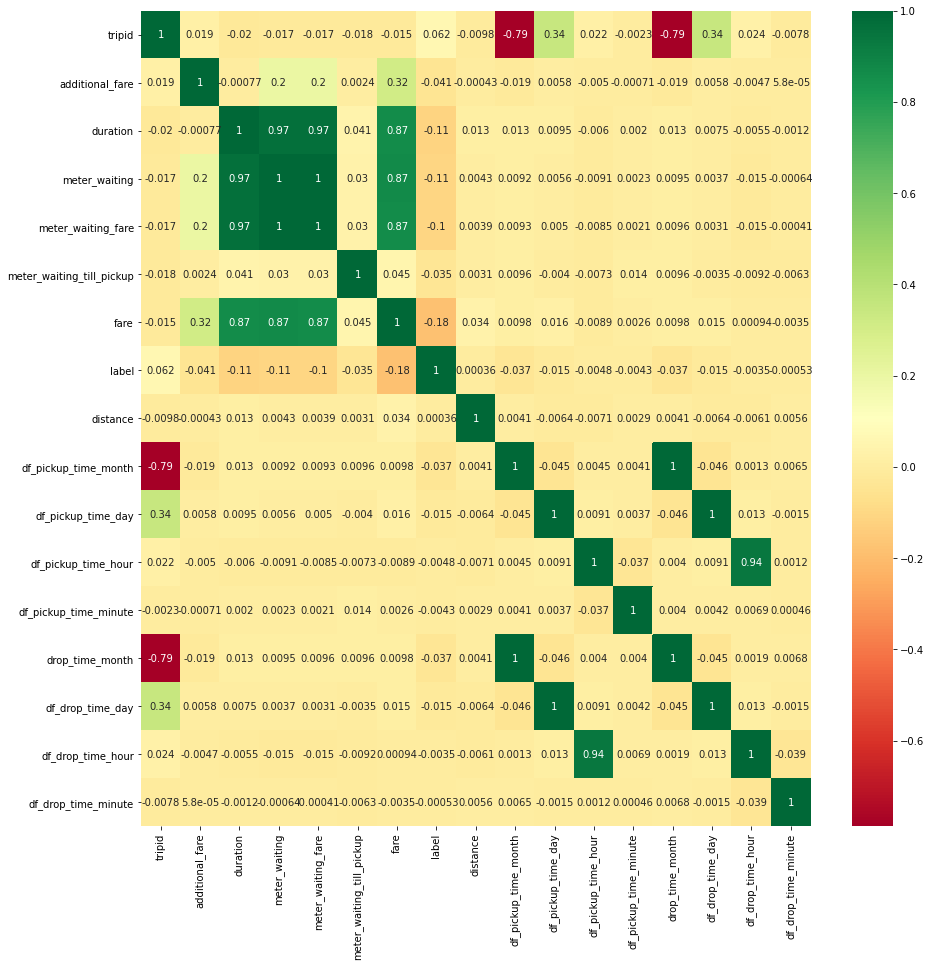

In [15]:
## Correlation
import seaborn as sns
import matplotlib.pyplot as plt
corrmat = df_ex.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(15,15))

#plot heat map
g=sns.heatmap(df_ex[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### Functions : New features

In [0]:
def calculate_fare_per_km(df):
  fare_per_km = []

  for i in range (len(df['fare'])):
    calculate_fare_per_km_value = df['fare'][i] / df['distance'][i]
    fare_per_km.append(calculate_fare_per_km_value)

  df['fare_per_km'] = fare_per_km

In [0]:
def calculate_fare_per_min(df):
  fare_per_second = []

  for i in range (len(df['fare'])):
    fare_per_second_value =  60 * df['fare'][i] / df['duration'][i]
    fare_per_second.append(fare_per_second_value)

  df['fare_per_min'] = fare_per_second

In [0]:
def calculate_speed(df):
  speed = []

  for i in range (len(df['fare'])):
    speed_value =  3600 * df['distance'][i] / (df['duration'][i] - df['meter_waiting'][i])
    speed.append(speed_value)

  df['speed'] = speed

In [0]:
# (Duration-meter_waiting)/fare

def calculate_real_duration_per_fare(df):
  real_duration_per_fare = []

  for i in range (len(df['fare'])):
    real_duration_per_fare_value =   (df['duration'][i] - df['meter_waiting'][i]) / df['fare'][i]
    real_duration_per_fare.append(real_duration_per_fare_value)

  df['real_duration_per_fare'] = real_duration_per_fare

In [0]:
def calculate_additional_fare_as_a_factor(df):
  additional_fare_as_a_factor = []

  for i in range (len(df['fare'])):
    additional_fare_as_a_factor_value =  df['additional_fare'][i] / df['fare'][i]
    additional_fare_as_a_factor.append(additional_fare_as_a_factor_value)

  df['additional_fare_as_a_factor'] = additional_fare_as_a_factor

In [0]:
def calculate_meter_waiting_fare_per_sec(df):
  meter_waiting_fare_per_sec = []

  for i in range (len(df['meter_waiting_fare'])):
    meter_waiting_fare_per_sec_value =  df['meter_waiting_fare'][i] / df['meter_waiting'][i]
    meter_waiting_fare_per_sec.append(meter_waiting_fare_per_sec_value)

  df['meter_waiting_fare_per_sec'] = meter_waiting_fare_per_sec

### Pre-process

In [0]:
def preprocess(df, features):
  features_loc = features
  generate_pickup_time(df)
  generate_drop_time(df)

  calculate_distance(df)


  calculate_fare_per_km(df)
  calculate_real_duration_per_fare(df)
  calculate_speed(df)
  calculate_additional_fare_as_a_factor(df)

  calculate_meter_waiting_fare_per_sec(df)

  calculate_fare_per_min(df)
  features_loc += ['meter_waiting_fare_per_sec', 'fare_per_min', 'additional_fare_as_a_factor', 'speed', 'real_duration_per_fare', 'distance', 'df_pickup_time_month', 'df_pickup_time_day', 'df_pickup_time_hour', 'df_pickup_time_minute', 'drop_time_month', 'df_drop_time_day', 'df_drop_time_hour', 'df_drop_time_minute']

  Features = df[features_loc]
  # Features = naImputation(Features,features) fare_per_km
  print(features)
  
  return Features

### Load train and test data

In [23]:
df = pd.read_csv('/content/drive/My Drive/Semester 7/ML/Project/Data/train.csv')
df['label'].replace(to_replace=['correct','incorrect'], value=[1,0],inplace=True)
features = ['additional_fare','duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'fare']
df

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,1
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,1
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,1
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,1
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17171,213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,1
17172,213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,1
17173,213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,1
17174,213815405,10.5,858.0,115.0,0.0000,317.0,1/31/2020 23:39,1/31/2020 23:53,6.94540,79.8768,6.93574,79.9010,133.31,1


In [24]:
Features = preprocess(df, features)
X = Features.to_numpy()
y = df['label'].values
Features.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'fare', 'meter_waiting_fare_per_sec', 'fare_per_min', 'additional_fare_as_a_factor', 'speed', 'real_duration_per_fare', 'distance', 'df_pickup_time_month', 'df_pickup_time_day', 'df_pickup_time_hour', 'df_pickup_time_minute', 'drop_time_month', 'df_drop_time_day', 'df_drop_time_hour', 'df_drop_time_minute']


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,meter_waiting_fare_per_sec,fare_per_min,additional_fare_as_a_factor,speed,real_duration_per_fare,distance,df_pickup_time_month,df_pickup_time_day,df_pickup_time_hour,df_pickup_time_minute,drop_time_month,df_drop_time_day,df_drop_time_hour,df_drop_time_minute
0,10.5,834.0,56.0,0.0000,64.0,270.32,0.0000,19.447482,0.038843,23.469707,2.878070,5.072065,11.0,1.0,0.0,20.0,11.0,1.0,0.0,34.0
1,10.5,791.0,47.0,0.0000,134.0,197.85,0.0000,15.007585,0.053071,15.250547,3.760425,3.151780,11.0,1.0,0.0,56.0,11.0,1.0,1.0,9.0
2,10.5,1087.0,80.0,0.0000,61.0,301.64,0.0000,16.649862,0.034810,22.530986,3.338417,6.302418,11.0,1.0,1.0,8.0,11.0,1.0,1.0,26.0
3,10.5,598.0,271.0,15.6638,68.0,82.30,0.0578,8.257525,0.127582,9.497113,3.973269,0.862654,11.0,1.0,2.0,27.0,11.0,1.0,2.0,37.0
4,NaN,NaN,NaN,NaN,NaN,358.39,NaN,NaN,NaN,NaN,NaN,8.148521,11.0,1.0,3.0,34.0,11.0,1.0,3.0,51.0


In [25]:
df_test = pd.read_csv('/content/drive/My Drive/Semester 7/ML/Project/Data/test.csv')
features_test = ['additional_fare','duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'fare']

Features_for_test = preprocess(df_test, features_test)
X_pred = Features_for_test.to_numpy()
Features_for_test.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'fare', 'meter_waiting_fare_per_sec', 'fare_per_min', 'additional_fare_as_a_factor', 'speed', 'real_duration_per_fare', 'distance', 'df_pickup_time_month', 'df_pickup_time_day', 'df_pickup_time_hour', 'df_pickup_time_minute', 'drop_time_month', 'df_drop_time_day', 'df_drop_time_hour', 'df_drop_time_minute']


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,meter_waiting_fare_per_sec,fare_per_min,additional_fare_as_a_factor,speed,real_duration_per_fare,distance,df_pickup_time_month,df_pickup_time_day,df_pickup_time_hour,df_pickup_time_minute,drop_time_month,df_drop_time_day,df_drop_time_hour,df_drop_time_minute
0,10.5,924,42,2.4486,148,289.27,0.058300,18.783766,0.036298,27.225263,3.049055,6.670189,2.0,1.0,0.0,38.0,2.0,1.0,0.0,53.0
1,10.5,4249,20,0.0000,91,1912.70,0.000000,27.009179,0.005490,35.200708,2.211011,41.351053,2.0,1.0,1.0,2.0,2.0,1.0,2.0,13.0
2,10.5,1552,255,2.6588,23,394.00,0.010427,15.231959,0.026650,16.431887,3.291878,5.920044,2.0,1.0,5.0,2.0,2.0,1.0,5.0,28.0
3,10.5,462,16,0.0000,198,154.32,0.000000,20.041558,0.068040,26.506110,2.890098,3.283813,2.0,1.0,5.0,30.0,2.0,1.0,5.0,38.0
4,10.5,814,392,12.3692,69,147.47,0.031554,10.870025,0.071201,22.086104,2.861599,2.588982,2.0,1.0,7.0,0.0,2.0,1.0,7.0,14.0


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
import xgboost

## Hyper-parameter tuning

### Random search

def xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=None, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

In [0]:
from sklearn.model_selection import RandomizedSearchCV
## Hyper Parameter Optimization

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.4, 0.5, 0.6,0.7, 0.8, 0.9] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 "subsamples" : [0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89,  0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
    
}

In [0]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [0]:
classifier=xgboost.XGBClassifier()

random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3, )

In [0]:
from datetime import datetime
# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X,y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   52.4s finished



 Time taken: 0 hours 0 minutes and 54.49 seconds.


In [0]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.4,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, subsamples=0.99, verbosity=1)

In [0]:
random_search.best_params_

{'colsample_bytree': 0.4,
 'gamma': 0.4,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 7,
 'subsamples': 0.99}

### Grid search

In [0]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'learning_rate' : [0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75],
    'subsamples' : [0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89,  0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0],
    'max_depth' : [1,2,3,4,5,6],
    'colsample_bytrees' : [ 0.1, 0.2, 0.3, 0.4, 0.5 , 0.7, 0.8, 0.9, 1],
    'min_child_weight' : [ 1, 3, 5, 7 ],
    'gammas':[ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
}

In [0]:
xgb_model = xgboost.XGBClassifier()

clf = GridSearchCV(xgb_model, parameters, n_jobs=10, 
                   scoring='f1_micro',
                   verbose=2, refit=True)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 249480 candidates, totalling 1247400 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   15.7s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   56.8s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:  4.4min
[Parallel(n_jobs=10)]: Done 993 tasks      | elapsed:  8.2min
[Parallel(n_jobs=10)]: Done 1438 tasks      | elapsed: 14.4min
[Parallel(n_jobs=10)]: Done 1965 tasks      | elapsed: 24.1min
[Parallel(n_jobs=10)]: Done 2572 tasks      | elapsed: 37.0min
[Parallel(n_jobs=10)]: Done 3261 tasks      | elapsed: 42.0min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed: 52.2min
[Parallel(n_jobs=10)]: Done 4881 tasks      | elapsed: 69.7min
[Parallel(n_jobs=10)]: Done 5812 tasks      | elapsed: 78.8min
[Parallel(n_jobs=10)]: Done 6825 tasks      | elapsed: 93.6min
[Parallel(n_jobs=10)]: Done 7918 tasks      | elapsed: 111.8min
[Parallel(n_jobs=10)]: Done 9093 tasks      |

In [0]:
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

### bayesian-optimization

In [31]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=f19ea389f9342db60cd1cbb2a969cb59940e7e9651ee2ef5dff30f55898d460a
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [0]:
xgb_model = xgboost.XGBClassifier(learning_rate=0.23)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [0]:
#Printing the classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.67      0.84      0.74       247
           1       0.99      0.97      0.98      3189

    accuracy                           0.96      3436
   macro avg       0.83      0.90      0.86      3436
weighted avg       0.96      0.96      0.96      3436



In [0]:
#Accuracy obtained on the training set
cm = confusion_matrix(y_pred, y_test)
acc = cm.diagonal().sum()/cm.sum()
print(acc)

0.9583818393480792


In [0]:
#Importing necessary libraries
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import mean_squared_error

#Converting the dataframe into XGBoost’s Dmatrix object
dtrain = xgb.DMatrix(X_train, y_train)

#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma, n_estimators ,learning_rate, colsample_bytree):
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'n_estimators': int(n_estimators),
              'learning_rate':learning_rate,
              'subsample': 0.8,
              'eta': 0.1,
              'colsample_bytree' : colsample_bytree,
              'eval_metric': 'rmse'}
    #Cross validating with the specified parameters in 5 folds and 70 iterations
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    #Return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 10),
                                             'gamma': (0, 1),
                                             'learning_rate':(0,1),
                                             'n_estimators':(100,1000),
                                            'colsample_bytree': (0,1)
                                            })

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------------------
|  1        | -0.2321   |  0.03916  |  0.5529   |  0.9257   |  6.869    |  931.0    |
|  2        | -0.1957   |  0.6519   |  0.6998   |  0.289    |  3.713    |  694.2    |
|  3        | -0.2002   |  0.7766   |  0.8701   |  0.5805   |  5.232    |  446.8    |
|  4        | -0.2111   |  0.5371   |  0.7899   |  0.8524   |  5.91     |  439.5    |
|  5        | -0.2319   |  0.01567  |  0.2427   |  0.4484   |  8.784    |  464.6    |
|  6        | -0.1931   |  0.4406   |  0.3556   |  0.1838   |  6.505    |  773.0    |
|  7        | -0.1942   |  0.9218   |  0.926    |  0.2138   |  3.574    |  781.9    |
|  8        | -0.1984   |  0.6465   |  0.000927 |  0.2543   |  9.236    |  140.5    |
|  9        | -0.5      |  1.0      |  1.0      |  0.0      |  3.0      |  100.0    |
|  10       | -0.5      |  1.0      |  1.0      |  0.0

In [0]:
#Extracting the best parameters
params = xgb_bo.max['params']
print(params)

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

#Initialize an XGBClassifier with the tuned parameters and fit the training data
from xgboost import XGBClassifier
classifier2 = XGBClassifier(**params).fit(X_train, y_train)

#predicting for training set
train_p2 = classifier2.predict(X_test)

#Looking at the classification report
print(classification_report(train_p2, y_test))

{'colsample_bytree': 0.44057572567710335, 'gamma': 0.3555540418763641, 'learning_rate': 0.18378697990906823, 'max_depth': 6.504564849878346, 'n_estimators': 772.9871117500487}
              precision    recall  f1-score   support

           0       0.68      0.82      0.74       256
           1       0.99      0.97      0.98      3180

    accuracy                           0.96      3436
   macro avg       0.83      0.89      0.86      3436
weighted avg       0.96      0.96      0.96      3436



In [0]:
#Attained prediction accuracy on the training set
cm = confusion_matrix(train_p2, y_test)
acc = cm.diagonal().sum()/cm.sum()
print(acc)

0.9575087310826542


## Train and predict

In [33]:
xgb_model = xgboost.XGBClassifier(colsample_bytree = 0.8282929969331484, gamma=0.8199636219552069,
                                  learning_rate= 0.48091390696028224, max_depth=4, n_estimators=817,
                                  scale_pos_weight=9)

# xgb_model = xgboost.XGBClassifier(scale_pos_weight=9)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print(f1_score(y_test, y_pred, average='macro'))

0.8679531647159182


In [0]:
y_pred_for_test = xgb_model.predict(X_pred)
y_pred_for_test

### submission

In [0]:
import csv

file_name = "submission_xgboost_all_new_features_06_13_test_split"

with open('/content/drive/My Drive/Semester 7/ML/Project/'+ file_name +'.csv', mode='w') as fare_file:
    writer = csv.writer(fare_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['tripid','prediction'])
    for i in range(len(y_pred_for_test)):
      writer.writerow([df_test['tripid'][i],y_pred_for_test[i]])